## import modules

In [1]:
!pip install torch==2.2
!pip install torchvision==0.17
!pip install matplotlib==3.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 5.3 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 0.26.1 requires graphviz, which is not installed.
catboost 0.26.1 requires plotly, which is not installed.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## define model architecture

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

## define training and inference routines

In [4]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))


In [5]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))


## create data loaders

In [6]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=False)

## define optimizer and run training epochs

In [7]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

## model training

In [8]:
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.310609
epoch: 1 [320/60000 (1%)]	 training loss: 1.924133
epoch: 1 [640/60000 (1%)]	 training loss: 1.313336
epoch: 1 [960/60000 (2%)]	 training loss: 0.796470
epoch: 1 [1280/60000 (2%)]	 training loss: 0.819801
epoch: 1 [1600/60000 (3%)]	 training loss: 0.678443
epoch: 1 [1920/60000 (3%)]	 training loss: 0.477794
epoch: 1 [2240/60000 (4%)]	 training loss: 0.527351
epoch: 1 [2560/60000 (4%)]	 training loss: 0.469222
epoch: 1 [2880/60000 (5%)]	 training loss: 0.243136
epoch: 1 [3200/60000 (5%)]	 training loss: 0.526528
epoch: 1 [3520/60000 (6%)]	 training loss: 0.271501
epoch: 1 [3840/60000 (6%)]	 training loss: 0.473249
epoch: 1 [4160/60000 (7%)]	 training loss: 0.425321
epoch: 1 [4480/60000 (7%)]	 training loss: 0.321529
epoch: 1 [4800/60000 (8%)]	 training loss: 0.492590
epoch: 1 [5120/60000 (9%)]	 training loss: 0.153583
epoch: 1 [5440/60000 (9%)]	 training loss: 0.378470
epoch: 1 [5760/60000 (10%)]	 training loss: 0.081257
epoch: 1 [6080/60

epoch: 2 [37440/60000 (62%)]	 training loss: 0.004772
epoch: 2 [37760/60000 (63%)]	 training loss: 0.067643
epoch: 2 [38080/60000 (63%)]	 training loss: 0.014400
epoch: 2 [38400/60000 (64%)]	 training loss: 0.029562
epoch: 2 [38720/60000 (65%)]	 training loss: 0.091197
epoch: 2 [39040/60000 (65%)]	 training loss: 0.013406
epoch: 2 [39360/60000 (66%)]	 training loss: 0.004593
epoch: 2 [39680/60000 (66%)]	 training loss: 0.168198
epoch: 2 [40000/60000 (67%)]	 training loss: 0.011329
epoch: 2 [40320/60000 (67%)]	 training loss: 0.245803
epoch: 2 [40640/60000 (68%)]	 training loss: 0.528659
epoch: 2 [40960/60000 (68%)]	 training loss: 0.044822
epoch: 2 [41280/60000 (69%)]	 training loss: 0.083322
epoch: 2 [41600/60000 (69%)]	 training loss: 0.153098
epoch: 2 [41920/60000 (70%)]	 training loss: 0.009117
epoch: 2 [42240/60000 (70%)]	 training loss: 0.011295
epoch: 2 [42560/60000 (71%)]	 training loss: 0.046957
epoch: 2 [42880/60000 (71%)]	 training loss: 0.005710
epoch: 2 [43200/60000 (72%)]

## run inference on trained model

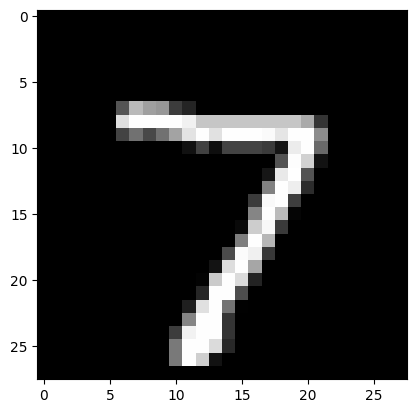

In [9]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [10]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 7
Ground truth is : 7
